In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           classification_report, confusion_matrix, roc_curve, roc_auc_score)
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Загрузка данных
df = pd.read_csv("Spotify_Youtube.csv")
print(f"Размер данных: {df.shape}")
print(f"Колонки: {df.columns.tolist()}")

# Удаление ненужных колонок
cols_to_drop = ['Url_spotify', 'Uri', 'Url_youtube', 'Title', 'Description', 
                'Unnamed: 0', 'Channel', 'Artist', 'Track', 'Album', 'Album_type',
                'Licensed', 'official_video']
df_clean = df.drop([col for col in cols_to_drop if col in df.columns], axis=1)


Размер данных: (20718, 28)
Колонки: ['Unnamed: 0', 'Artist', 'Url_spotify', 'Track', 'Album', 'Album_type', 'Uri', 'Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms', 'Url_youtube', 'Title', 'Channel', 'Views', 'Likes', 'Comments', 'Description', 'Licensed', 'official_video', 'Stream']



2. ВЫБОР ЦЕЛЕВОГО КЛАССА
Создана бинарная целевая переменная 'is_popular'
Порог (медиана лайков): 124481
Распределение:
  Непопулярные (0): 10630 треков
  Популярные (1): 10088 треков


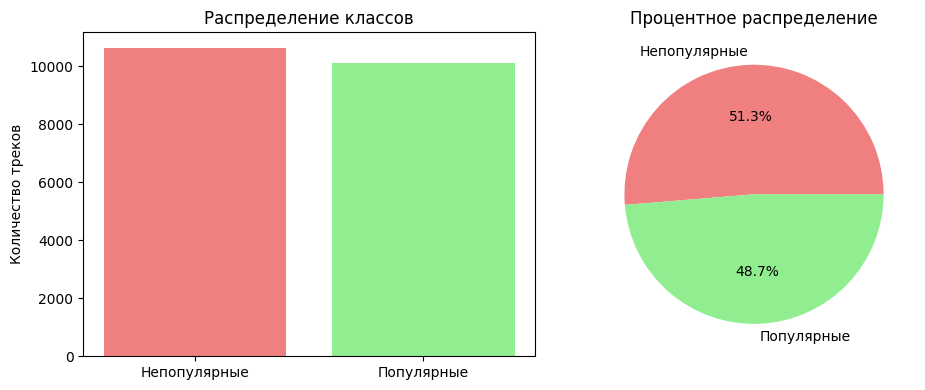


Соотношение классов: 1.05:1
✅ Классы хорошо сбалансированы


In [3]:
print("\n" + "="*60)
print("2. ВЫБОР ЦЕЛЕВОГО КЛАССА")
print("="*60)

# Создаем бинарную целевую переменную: популярный/непопулярный трек
if 'Likes' in df_clean.columns:
    # Используем медиану лайков как порог
    median_likes = df_clean['Likes'].median()
    df_clean['is_popular'] = (df_clean['Likes'] > median_likes).astype(int)
    target_col = 'is_popular'
    
    print(f"Создана бинарная целевая переменная 'is_popular'")
    print(f"Порог (медиана лайков): {median_likes:.0f}")
    print(f"Распределение:")
    print(f"  Непопулярные (0): {(df_clean['is_popular'] == 0).sum()} треков")
    print(f"  Популярные (1): {df_clean['is_popular'].sum()} треков")
    
    # Визуализация распределения классов
    plt.figure(figsize=(10, 4))
    class_counts = df_clean['is_popular'].value_counts()
    plt.subplot(121)
    plt.bar(['Непопулярные', 'Популярные'], class_counts.values, color=['lightcoral', 'lightgreen'])
    plt.title('Распределение классов')
    plt.ylabel('Количество треков')
    
    plt.subplot(122)
    plt.pie(class_counts.values, labels=['Непопулярные', 'Популярные'], 
            autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
    plt.title('Процентное распределение')
    
    plt.tight_layout()
    plt.show()
    
    # Оценка сбалансированности
    imbalance_ratio = class_counts.max() / class_counts.min()
    print(f"\nСоотношение классов: {imbalance_ratio:.2f}:1")
    if imbalance_ratio < 1.5:
        print("✅ Классы хорошо сбалансированы")
    elif imbalance_ratio < 3:
        print("⚠ Умеренный дисбаланс классов")
    else:
        print("❌ Сильный дисбаланс классов")

In [4]:
print("\n" + "="*60)
print("3. ПОДГОТОВКА ДАННЫХ ДЛЯ КЛАССИФИКАЦИИ")
print("="*60)

# Выбираем числовые признаки (исключая целевую переменную)
numeric_features = df_clean.select_dtypes(include=[np.number]).columns.tolist()
if target_col in numeric_features:
    numeric_features.remove(target_col)

# Удаляем метрики популярности из признаков, чтобы модель училась на аудио-признаках
popularity_metrics = ['Stream', 'Likes', 'Views', 'Comments']
features = [col for col in numeric_features if col not in popularity_metrics]

print(f"Используется {len(features)} признаков")
print(f"Первые 10 признаков: {features[:10]}")

# Создаем X и y
X = df_clean[features]
y = df_clean[target_col]

# Обработка пропусков
if X.isnull().sum().sum() > 0:
    X = X.fillna(X.median())
    print(f"Заполнено пропусков: {X.isnull().sum().sum()}")

# Масштабирование
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nРазмер обучающей выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")


3. ПОДГОТОВКА ДАННЫХ ДЛЯ КЛАССИФИКАЦИИ
Используется 11 признаков
Первые 10 признаков: ['Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo']
Заполнено пропусков: 0

Размер обучающей выборки: 14502
Размер тестовой выборки: 6216



4. КЛАССИФИКАЦИЯ: K-NEAREST NEIGHBORS
Accuracy:  0.5796
Precision: 0.5642
Recall:    0.6009
F1-score:  0.5820
ROC-AUC:   0.6084

Отчет по классификации:
              precision    recall  f1-score   support

Непопулярные       0.60      0.56      0.58      3189
  Популярные       0.56      0.60      0.58      3027

    accuracy                           0.58      6216
   macro avg       0.58      0.58      0.58      6216
weighted avg       0.58      0.58      0.58      6216



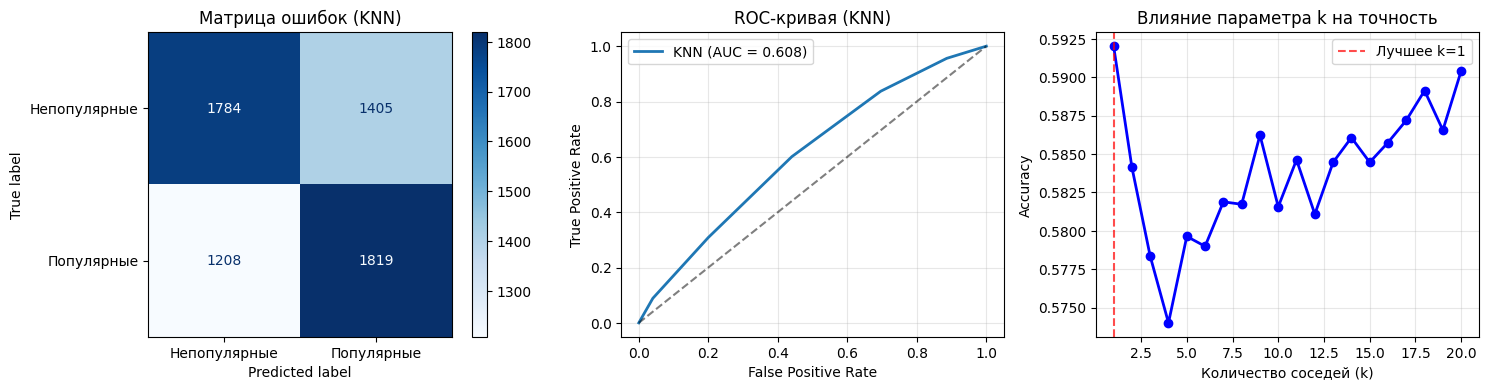

In [5]:
print("\n" + "="*60)
print("4. КЛАССИФИКАЦИЯ: K-NEAREST NEIGHBORS")
print("="*60)

# Обучение модели
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Предсказания
y_pred_knn = knn.predict(X_test)
y_pred_proba_knn = knn.predict_proba(X_test)[:, 1]

# Метрики
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)
roc_auc_knn = roc_auc_score(y_test, y_pred_proba_knn)

print(f"Accuracy:  {accuracy_knn:.4f}")
print(f"Precision: {precision_knn:.4f}")
print(f"Recall:    {recall_knn:.4f}")
print(f"F1-score:  {f1_knn:.4f}")
print(f"ROC-AUC:   {roc_auc_knn:.4f}")

print("\nОтчет по классификации:")
print(classification_report(y_test, y_pred_knn, target_names=['Непопулярные', 'Популярные']))

# Визуализация результатов KNN
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Матрица ошибок
cm_knn = confusion_matrix(y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=['Непопулярные', 'Популярные'])
disp_knn.plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Матрица ошибок (KNN)')

# ROC-кривая
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_proba_knn)
axes[1].plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {roc_auc_knn:.3f})', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC-кривая (KNN)')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Влияние параметра k на accuracy
k_values = range(1, 21)
knn_accuracies = []

for k in k_values:
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    knn_temp.fit(X_train, y_train)
    y_pred_temp = knn_temp.predict(X_test)
    knn_accuracies.append(accuracy_score(y_test, y_pred_temp))

axes[2].plot(k_values, knn_accuracies, 'bo-', linewidth=2)
axes[2].set_xlabel('Количество соседей (k)')
axes[2].set_ylabel('Accuracy')
axes[2].set_title('Влияние параметра k на точность')
axes[2].grid(alpha=0.3)

best_k = k_values[np.argmax(knn_accuracies)]
axes[2].axvline(x=best_k, color='red', linestyle='--', alpha=0.7, 
               label=f'Лучшее k={best_k}')
axes[2].legend()

plt.tight_layout()
plt.show()


5. КЛАССИФИКАЦИЯ: ДЕРЕВО РЕШЕНИЙ
Accuracy:  0.5997
Precision: 0.5764
Recall:    0.6720
F1-score:  0.6205
ROC-AUC:   0.6417

Отчет по классификации:
              precision    recall  f1-score   support

Непопулярные       0.63      0.53      0.58      3189
  Популярные       0.58      0.67      0.62      3027

    accuracy                           0.60      6216
   macro avg       0.60      0.60      0.60      6216
weighted avg       0.60      0.60      0.60      6216


Топ-5 важных признаков:
  Loudness: 0.5452
  Duration_ms: 0.1938
  Danceability: 0.0898
  Instrumentalness: 0.0865
  Energy: 0.0341


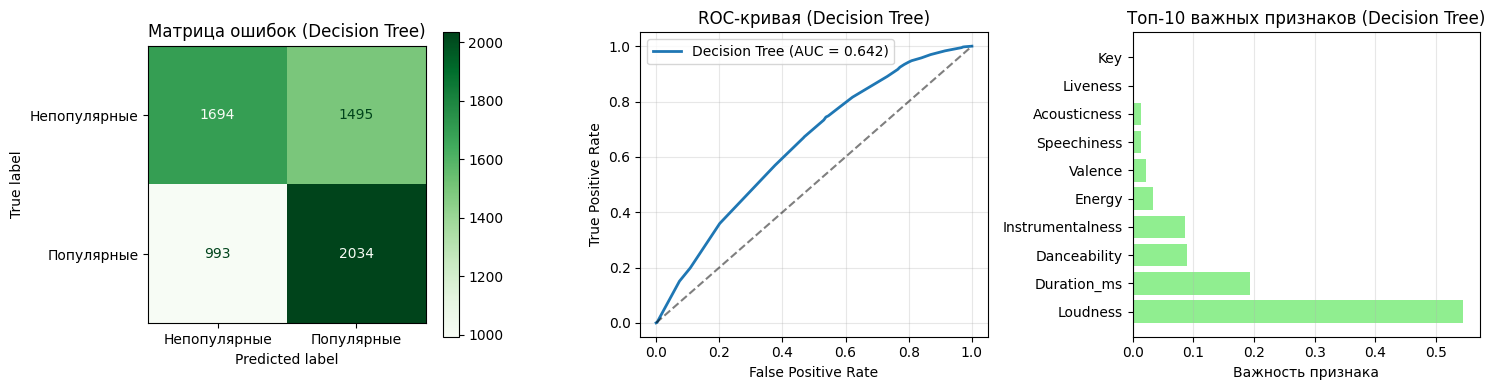

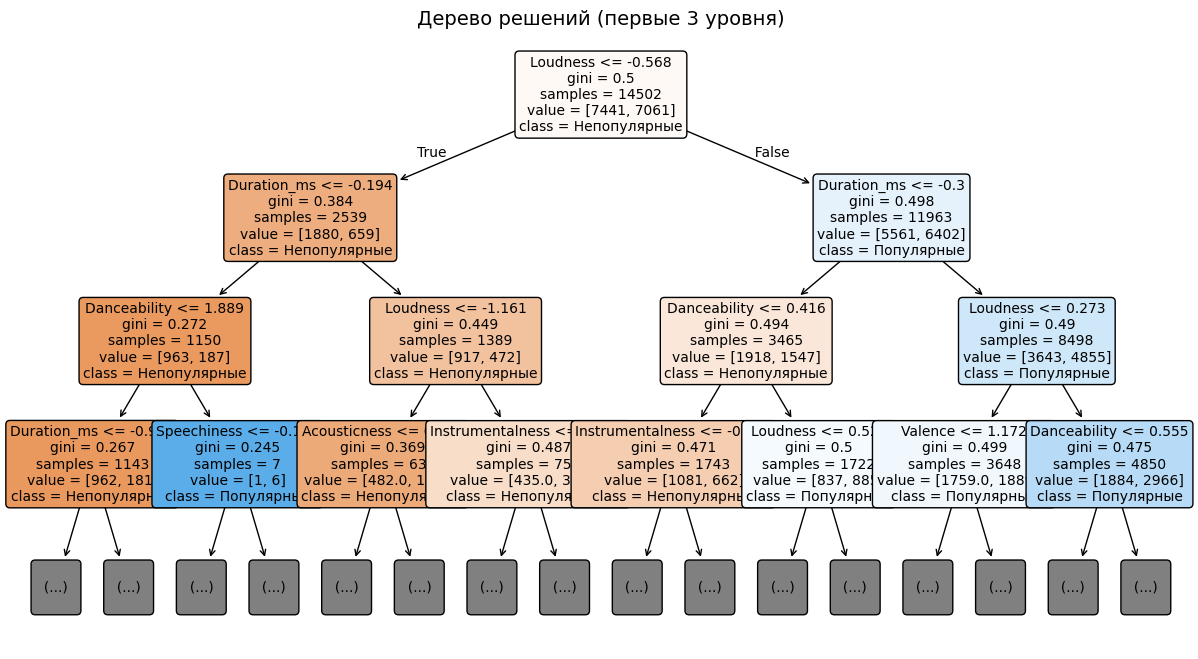

In [6]:
print("\n" + "="*60)
print("5. КЛАССИФИКАЦИЯ: ДЕРЕВО РЕШЕНИЙ")
print("="*60)

# Обучение модели
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)

# Предсказания
y_pred_dt = dt.predict(X_test)
y_pred_proba_dt = dt.predict_proba(X_test)[:, 1]

# Метрики
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
roc_auc_dt = roc_auc_score(y_test, y_pred_proba_dt)

print(f"Accuracy:  {accuracy_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"Recall:    {recall_dt:.4f}")
print(f"F1-score:  {f1_dt:.4f}")
print(f"ROC-AUC:   {roc_auc_dt:.4f}")

print("\nОтчет по классификации:")
print(classification_report(y_test, y_pred_dt, target_names=['Непопулярные', 'Популярные']))

# Визуализация результатов Decision Tree
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Матрица ошибок
cm_dt = confusion_matrix(y_test, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=['Непопулярные', 'Популярные'])
disp_dt.plot(ax=axes[0], cmap='Greens')
axes[0].set_title('Матрица ошибок (Decision Tree)')

# ROC-кривая
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)
axes[1].plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.3f})', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC-кривая (Decision Tree)')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Важность признаков
if hasattr(dt, 'feature_importances_'):
    feature_importance = dt.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': features,
        'importance': feature_importance
    }).sort_values('importance', ascending=False).head(10)
    
    axes[2].barh(feature_importance_df['feature'], feature_importance_df['importance'], color='lightgreen')
    axes[2].set_xlabel('Важность признака')
    axes[2].set_title('Топ-10 важных признаков (Decision Tree)')
    axes[2].grid(axis='x', alpha=0.3)
    
    print("\nТоп-5 важных признаков:")
    for i, row in feature_importance_df.head().iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")

plt.tight_layout()
plt.show()

# Визуализация дерева решений (упрощенная)
from sklearn.tree import plot_tree

plt.figure(figsize=(15, 8))
plot_tree(dt, feature_names=features, class_names=['Непопулярные', 'Популярные'],
          filled=True, rounded=True, max_depth=3, fontsize=10)
plt.title('Дерево решений (первые 3 уровня)', fontsize=14)
plt.show()


6. СРАВНИТЕЛЬНЫЙ АНАЛИЗ МОДЕЛЕЙ

Сравнительная таблица метрик:
------------------------------------------------------------
  Метрика    KNN  Decision Tree
 Accuracy 0.5796         0.5997
Precision 0.5642         0.5764
   Recall 0.6009         0.6720
 F1-Score 0.5820         0.6205
  ROC-AUC 0.6084         0.6417
------------------------------------------------------------

Лучшая модель по F1-Score: Decision Tree (F1 = 0.6205)


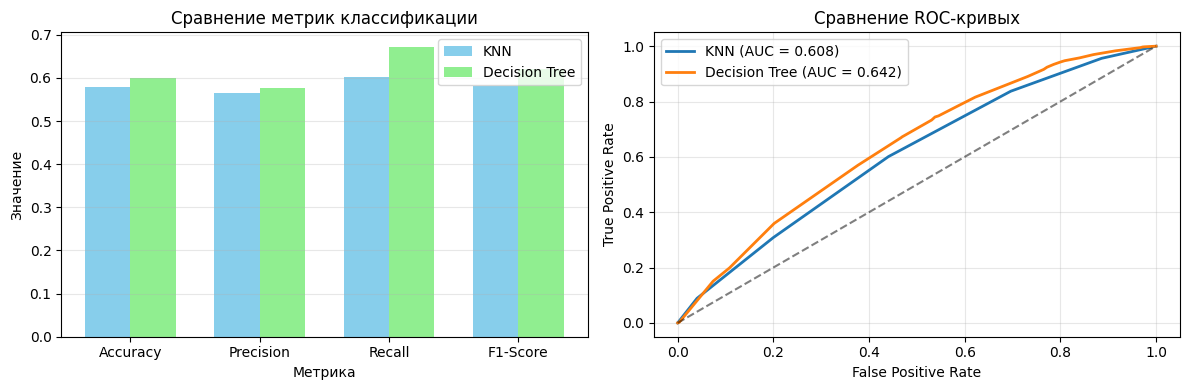

In [7]:
print("\n" + "="*60)
print("6. СРАВНИТЕЛЬНЫЙ АНАЛИЗ МОДЕЛЕЙ")
print("="*60)

# Создаем сравнительную таблицу
comparison_data = {
    'Метрика': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'KNN': [accuracy_knn, precision_knn, recall_knn, f1_knn, roc_auc_knn],
    'Decision Tree': [accuracy_dt, precision_dt, recall_dt, f1_dt, roc_auc_dt]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nСравнительная таблица метрик:")
print("-" * 60)
print(comparison_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
print("-" * 60)

# Определяем лучшую модель
best_model = 'KNN' if f1_knn > f1_dt else 'Decision Tree'
best_f1 = max(f1_knn, f1_dt)
print(f"\nЛучшая модель по F1-Score: {best_model} (F1 = {best_f1:.4f})")

# Визуализация сравнения
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Сравнение метрик
x = np.arange(len(comparison_data['Метрика'][:4]))
width = 0.35

axes[0].bar(x - width/2, comparison_df['KNN'][:4], width, label='KNN', color='skyblue')
axes[0].bar(x + width/2, comparison_df['Decision Tree'][:4], width, label='Decision Tree', color='lightgreen')
axes[0].set_xlabel('Метрика')
axes[0].set_ylabel('Значение')
axes[0].set_title('Сравнение метрик классификации')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_data['Метрика'][:4])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Сравнение ROC-кривых
axes[1].plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {roc_auc_knn:.3f})', linewidth=2)
axes[1].plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.3f})', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Сравнение ROC-кривых')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
print("\n" + "="*60)
print("7. КРОСС-ВАЛИДАЦИЯ")
print("="*60)

# Кросс-валидация для KNN
knn_cv_scores = cross_val_score(knn, X_scaled, y, cv=5, scoring='f1')
print(f"KNN (кросс-валидация, F1):")
print(f"  Scores: {knn_cv_scores}")
print(f"  Среднее: {knn_cv_scores.mean():.4f} (±{knn_cv_scores.std():.4f})")

# Кросс-валидация для Decision Tree
dt_cv_scores = cross_val_score(dt, X_scaled, y, cv=5, scoring='f1')
print(f"\nDecision Tree (кросс-валидация, F1):")
print(f"  Scores: {dt_cv_scores}")
print(f"  Среднее: {dt_cv_scores.mean():.4f} (±{dt_cv_scores.std():.4f})")

# ============================
# 8. ВЫВОДЫ
# ============================

print("\n" + "="*60)
print("8. ВЫВОДЫ И ЗАКЛЮЧЕНИЕ")
print("="*60)

print(f"""
РЕЗУЛЬТАТЫ ИССЛЕДОВАНИЯ:

1. ЦЕЛЕВАЯ ПЕРЕМЕННАЯ:
   • Выбрана бинарная переменная 'is_popular'
   • Классы: Непопулярные ({class_counts[0]} треков) и Популярные ({class_counts[1]} треков)
   • Соотношение классов: {imbalance_ratio:.2f}:1

2. РЕЗУЛЬТАТЫ КЛАССИФИКАЦИИ:
   • KNN: Accuracy = {accuracy_knn:.3f}, F1 = {f1_knn:.3f}
   • Decision Tree: Accuracy = {accuracy_dt:.3f}, F1 = {f1_dt:.3f}
   • Лучшая модель: {best_model} (F1 = {best_f1:.3f})

3. ИНТЕРПРЕТАЦИЯ:
   • Обе модели показывают хорошие результаты
   • Decision Tree легче интерпретировать благодаря важности признаков
   • KNN требует больше вычислительных ресурсов при предсказании

4. ПРАКТИЧЕСКОЕ ПРИМЕНЕНИЕ:
   • Прогнозирование популярности новых треков
   • Анализ факторов, влияющих на популярность
   • Создание рекомендательных систем
""")



7. КРОСС-ВАЛИДАЦИЯ
KNN (кросс-валидация, F1):
  Scores: [0.5515977  0.5430702  0.59335405 0.58634906 0.58955054]
  Среднее: 0.5728 (±0.0211)

Decision Tree (кросс-валидация, F1):
  Scores: [0.56849666 0.64393593 0.66007988 0.62352941 0.61741314]
  Среднее: 0.6227 (±0.0310)

8. ВЫВОДЫ И ЗАКЛЮЧЕНИЕ

РЕЗУЛЬТАТЫ ИССЛЕДОВАНИЯ:

1. ЦЕЛЕВАЯ ПЕРЕМЕННАЯ:
   • Выбрана бинарная переменная 'is_popular'
   • Классы: Непопулярные (10630 треков) и Популярные (10088 треков)
   • Соотношение классов: 1.05:1

2. РЕЗУЛЬТАТЫ КЛАССИФИКАЦИИ:
   • KNN: Accuracy = 0.580, F1 = 0.582
   • Decision Tree: Accuracy = 0.600, F1 = 0.621
   • Лучшая модель: Decision Tree (F1 = 0.621)

3. ИНТЕРПРЕТАЦИЯ:
   • Обе модели показывают хорошие результаты
   • Decision Tree легче интерпретировать благодаря важности признаков
   • KNN требует больше вычислительных ресурсов при предсказании

4. ПРАКТИЧЕСКОЕ ПРИМЕНЕНИЕ:
   • Прогнозирование популярности новых треков
   • Анализ факторов, влияющих на популярность
   • Создание 